# 6. Tropospheric Correction

## 6.1. Notebook setup

In [1]:
import os
import sys

from astropy import coordinates as coord, units as u
from cmcrameri import cm as cmc
import emcee
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import smplotlib

In [2]:
epochs = ["A", "B", "C", "D", "E", "F"]
data_path = "../data/"
fig_path = "../figures/"
calibrator = "J0340"
target = "HR1099"

cm = [
    "#377eb8",
    "#e41a1c",
    "#4daf4a",
    "#dede00",
    "#ff7f00",
    "#999999",
    "#984ea3",
    "#f781bf",
    "#a65628",
]
marker_cycle = ["o", "v", "X", "<", "D", "^"]

sys.path.append(os.path.join(os.getcwd(), ".."))
from library import HR1099_astrometry, utils

deg = np.pi / 180
mas = deg / (60 * 60 * 1000)

hr1099 = coord.SkyCoord(ra="03h36m47.256031s", dec="+00d35m13.350520s", frame="icrs")
target_ra = r"$03^{\rm h}36^{\rm m}47\overset{{\rm s}}{.}256031$"
target_dec = r"$+00^{\circ}35^{\prime}13\overset{\prime\prime}{.}350520$"

## 6.2. Import data

In [3]:
mean_jd = np.genfromtxt(
    data_path + target + "_I_positions.txt",
    skip_header=2,
    dtype="U5,f8,f8,f8,f8,f8,f8,f8",
    usecols=(5),
    unpack=True,
)
mean_mjd = np.round(mean_jd - 2400000.5, 1)

calibrator_results = {}
for epoch in epochs:
    x, y, jd, x_err, y_err = np.genfromtxt(
        data_path + epoch + "_" + calibrator + "_I_sub-epoch_positions.txt",
        skip_header=2,
        dtype="U1,f8,f8,f8,f8,f8,f8,f8",
        usecols=(2, 3, 5, 6, 7),
        unpack=True,
    )

    calibrator_results[epoch] = np.array([jd, x, y, x_err, y_err])

target_results = {}
for epoch in epochs:
    x, y, jd, x_err, y_err = np.genfromtxt(
        data_path + epoch + "_" + target + "_I_sub-epoch_positions.txt",
        skip_header=2,
        dtype="U1,f8,f8,f8,f8,f8,f8,f8",
        usecols=(2, 3, 5, 6, 7),
        unpack=True,
    )

    target_results[epoch] = np.array([jd, x, y, x_err, y_err])

sampler = emcee.backends.HDFBackend(data_path + target + "_orbital_chain.h5")
flat_samples = sampler.get_chain(flat=True)
flat_samples = np.divide(flat_samples, np.array([1, 1, deg, deg]))

med_val = np.percentile(flat_samples, [16, 50, 84], axis=0)
lower_val = med_val[1] - med_val[0]
upper_val = med_val[2] - med_val[1]
med_val = med_val[1]

hr1099 = HR1099_astrometry.HR1099_astrometry(med_val[2] * deg, med_val[3] * deg)

## 6.3. Plot

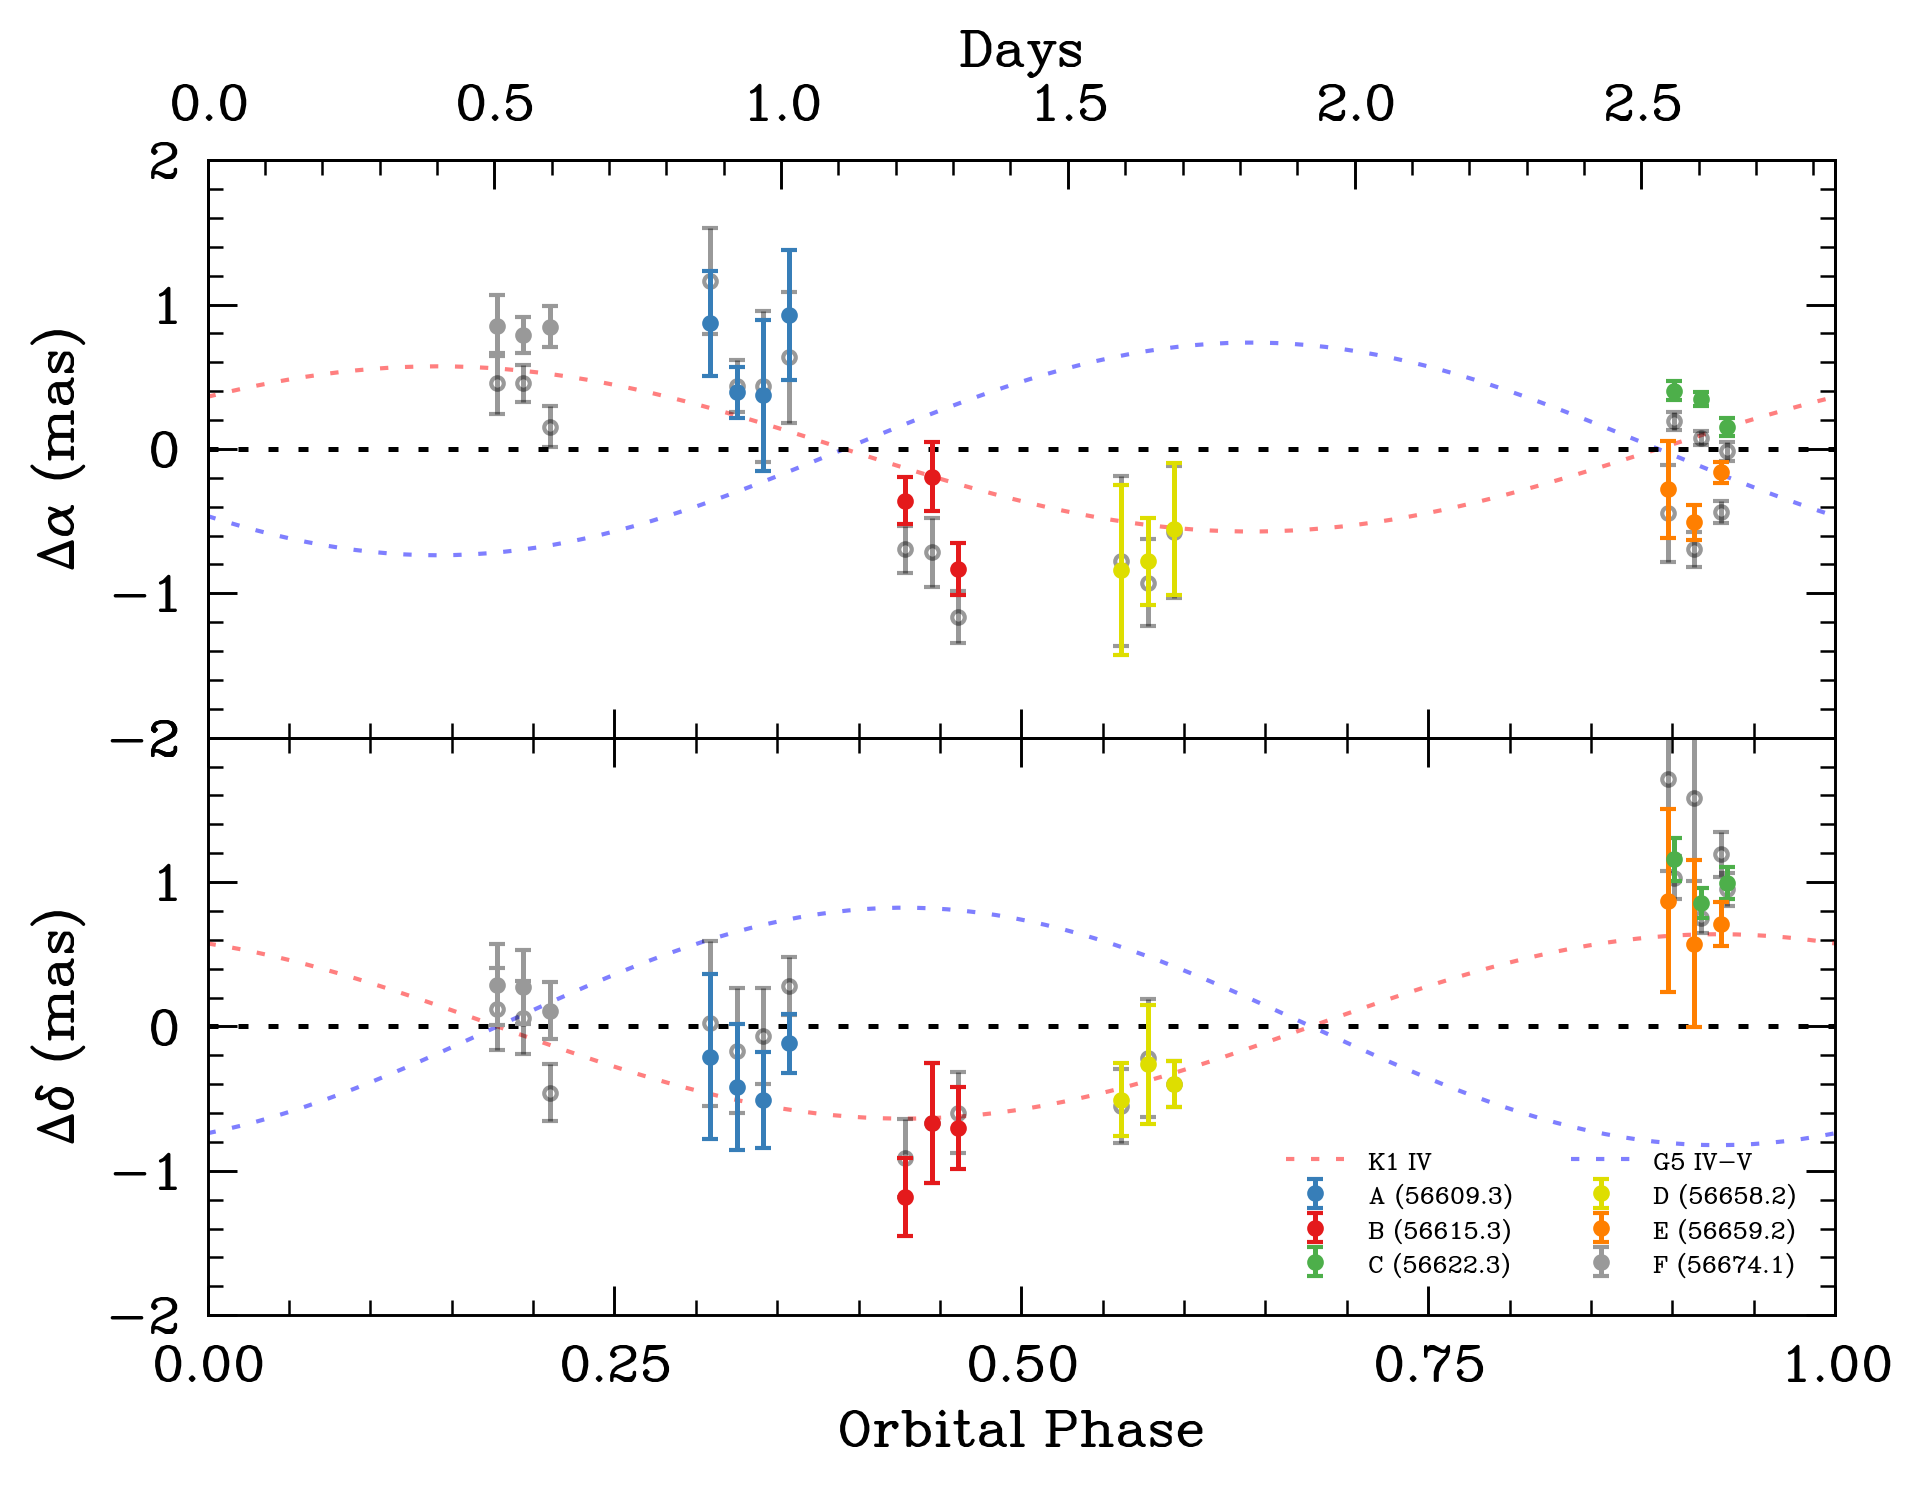

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)

orbit_range = np.linspace(HR1099_astrometry.T, HR1099_astrometry.T + HR1099_astrometry.P / 60 / 60 / 24, 100)
orbital_phase = np.array([hr1099.orbit_phase(t) for t in orbit_range])

ra = []; ra_sec = []
dec = []; dec_sec = []
for t in orbit_range:
    ra1, dec1, ra2, dec2, rho1, rho2, phi = hr1099.binary_offsets(t)
    ra.append(ra1)
    dec.append(dec1)
    ra_sec.append(ra2)
    dec_sec.append(dec2)
ra = np.array(ra)
dec = np.array(dec)
ra_sec = np.array(ra_sec)
dec_sec = np.array(dec_sec)

ax[0].plot(orbital_phase, ra/mas, color='red', label="K1 IV", linewidth=1, linestyle="dotted", alpha=0.5)
ax[1].plot(orbital_phase, dec/mas, color='red', linewidth=1, linestyle="dotted", alpha=0.5)

for i, epoch in enumerate(epochs):
    jd, x, y, x_err, y_err = target_results[epoch]
    cal_jd, cal_x, cal_y, cal_x_err, cal_y_err = calibrator_results[epoch]
    phs = np.array([hr1099.orbit_phase(time) for time in jd])

    ax[0].errorbar(phs, x + med_val[0], yerr=x_err, fmt="o", color=cm[i], markersize=3, zorder=10, label="%s (%.1f)" % (epoch, mean_mjd[epochs.index(epoch)]))
    ax[1].errorbar(phs, y + med_val[1], yerr=y_err, fmt="o", color=cm[i], markersize=3, zorder=10)

    ax[0].errorbar(phs, x + med_val[0] - 2.1*cal_x, yerr=x_err, color="black", markersize=3, zorder=9, alpha=0.4, 
        markerfacecolor="none", markeredgecolor="black", linestyle="none", marker="o")
    ax[1].errorbar(phs, y + med_val[1] - 2.1*cal_y, yerr=y_err, color="black", markersize=3, zorder=9, alpha=0.4, 
        markerfacecolor="none", markeredgecolor="black", linestyle="none", marker="o")

ax[0].plot(orbital_phase, ra_sec/mas, color='blue', label="G5 IV-V", linewidth=1, linestyle="dotted", alpha=0.5)
ax[1].plot(orbital_phase, dec_sec/mas, color='blue', linewidth=1, linestyle="dotted", alpha=0.5)

ax[0].axhline(0, color="black", linestyle="dotted")
ax[1].axhline(0, color="black", linestyle="dotted")

ax[0].set_xlim(0, 1)
ax[0].set_ylim(-2, 2)
ax[0].set_ylabel(r"$\Delta\alpha$ (mas)")
ax[0].xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax[0].xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax[1].set_xlabel("Orbital Phase")
ax[1].set_ylabel(r"$\Delta\delta$ (mas)")

axz = ax[0].twiny()
axz.set_xlim(0, HR1099_astrometry.P / 60 / 60 / 24)
axz.set_xlabel("Days")

handles, labels = ax[0].get_legend_handles_labels()
order = [0, 2, 3, 4, 1, 5, 6, 7]
ax[1].legend([handles[i] for i in order], [labels[i] for i in order], loc="lower right", ncol=2, fontsize=7)

fig.set_facecolor("white")
fig.set_dpi(300)
fig.savefig(fig_path + "tropospheric_correction.pdf", bbox_inches="tight")
plt.show()